Notes: prediction only with a pretrained model.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.segmentation import relabel_sequential
from tifffile import imread
from stardist.matching import matching, matching_dataset, group_matching_labels
from tqdm import tqdm
from skimage.segmentation import relabel_sequential
import statistics

import sys
import os
from pathlib import Path

cwd = os.getcwd()
# print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[2])
# print(f"Module dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.tools.utils import load_yaml
from src.data.preprocess_utils import load_files, resample_crop_downsample

import seaborn as sns
sns.set(font_scale=1.2)
sns.set_palette("Set2")

## Experiments´ directories

In [4]:
base_dir = os.path.join(module_path, "experiments")

exp_dir1 = os.path.join(base_dir, "exp13")     # filter state - True, sigma 1
exp_dir2 = os.path.join(base_dir, "exp13-1")   # filter state - True, sigma 2
exp_dir3 = os.path.join(base_dir, "exp13-2")   # filter state - True, sigma 3
exp_dir0 = os.path.join(base_dir, "exp13-3")   # filter state - False

In [5]:
Path(os.path.join(module_path, "reports", "figures", "plantseg")).mkdir(parents=True, exist_ok=True)   # create dir to save figures

In [82]:
exp_dir_extra = os.path.join(base_dir, "exp14-1_pred")   # filter state - False

In [ ]:
raw = load_files(os.path.join(module_path, "data", "plantseg_train_val_test_2022-08-17", "test", "raw"))
y_true, fnames = load_files(os.path.join(module_path, "data", "plantseg_train_val_test_2022-08-17", "test", "labels"), return_fnames=True)

## Load predictions

In [ ]:
pred1 = load_files(os.path.join(exp_dir1, "results", "Segmentation", "PostProcessing"))
pred2 = load_files(os.path.join(exp_dir2, "results", "Segmentation", "PostProcessing"))
pred3 = load_files(os.path.join(exp_dir3, "results", "Segmentation", "PostProcessing"))
pred0 = load_files(os.path.join(exp_dir0, "results", "Segmentation", "PostProcessing"))

In [ ]:
pred_extra = load_files(os.path.join(exp_dir_extra, "results", "Segmentation", "PostProcessing"))

## Metrics

In [15]:
metrics1 = matching_dataset(np.array(y_true).astype("int32"), np.array(pred1).astype("int32"), thresh=0.3, show_progress=False)

In [7]:
metrics2 = matching_dataset(np.array(y_true).astype("int32"), np.array(pred2).astype("int32"), thresh=0.3, show_progress=False)

In [8]:
metrics3 = matching_dataset(np.array(y_true).astype("int32"), np.array(pred3).astype("int32"), thresh=0.3, show_progress=False)

In [9]:
metrics0 = matching_dataset(np.array(y_true).astype("int32"), np.array(pred0).astype("int32"), thresh=0.3, show_progress=False)

In [84]:
metrics = matching_dataset(np.array(y_true).astype("int32"), np.array(pred_extra).astype("int32"), thresh=0.3, show_progress=False)

### Dependance on filtering before UNET prediction

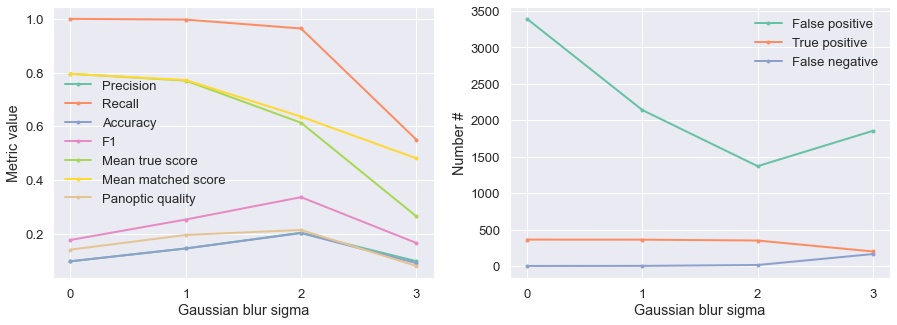

In [90]:
metrics = [metrics0, metrics1, metrics2, metrics3]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

labels = ('Precision', 'Recall', 'Accuracy', 'F1', 'Mean true score', 'Mean matched score', 'Panoptic quality')

for m,lbl in zip(('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'),labels):
    ax1.plot([0, 1, 2, 3], [s._asdict()[m] for s in metrics], '.-', lw=2, label=lbl)
ax1.set_xlabel(r'Gaussian blur sigma')
ax1.set_ylabel('Metric value')
ax1.grid(True)
ax1.set_xticks([0, 1, 2, 3])
ax1.legend(frameon=False)

labels=('False positive', 'True positive', 'False negative')
for m,lbl in zip(('fp', 'tp', 'fn'), labels):
    ax2.plot([0, 1, 2, 3], [s._asdict()[m] for s in metrics], '.-', lw=2, label=lbl)
ax2.set_xlabel(r'Gaussian blur sigma')
ax2.set_ylabel('Number #')
ax2.grid(True)
ax2.set_xticks([0, 1, 2, 3])
ax2.legend(frameon=False)

plt.savefig(os.path.join(module_path, "reports", "figures", "plantseg", "plantseg_filter.png"), bbox_inches='tight')

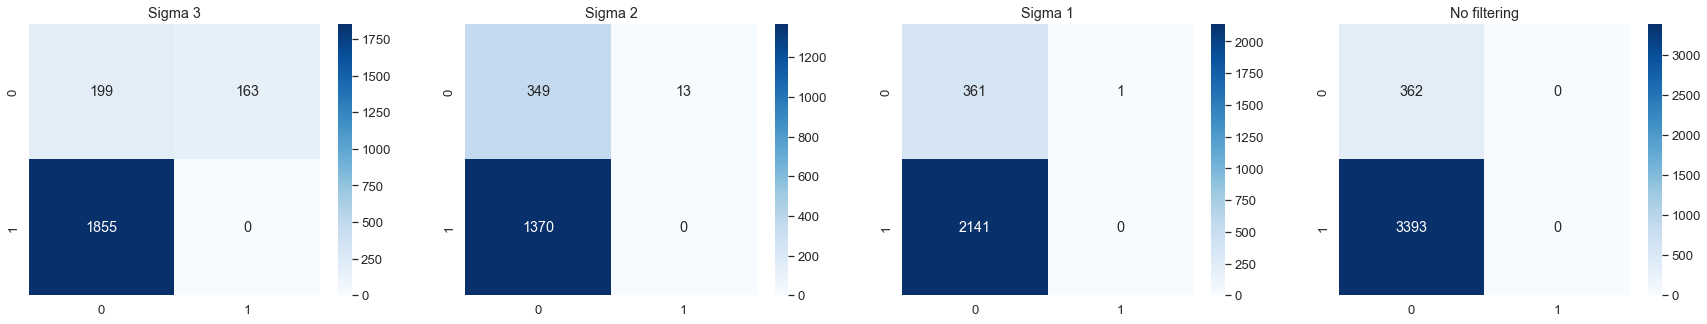

In [93]:
metrics = [metrics3, metrics2, metrics1, metrics0]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30,5))
labels = ["Sigma 3", "Sigma 2", "Sigma 1", "No filtering"]
for met, ax,lbl in zip(metrics, axes.flatten(), labels):
    cm_data_1 = []
    cm_data_2 = []

    for m in ('tp', 'fn', 'fp'):
        if m == "tp" or m == "fn":
            cm_data_1.append(met._asdict()[m])
        elif m == "fp":
            cm_data_2.append(met._asdict()[m])

    cm_data_2.append(0)  # tn are not known
    cm_data = [cm_data_1, cm_data_2]
    sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.title.set_text(lbl)

plt.savefig(os.path.join(module_path, "reports", "figures", "plantseg", "plantseg_filter_cm.png"), bbox_inches='tight')